# Lab 10

### <span style="color:chocolate"> Submission requirements </span>

Your homework will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = './10_images/' # replace with your path
LABEL_PATH = './10_labels/' # replace with your path
print(os.getcwd())

/tmp/ipykernel_151624/974422406.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-23 15:52:19.295644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 15:52:19.295672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 15:52:19.296789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

/home/davidsolow/projects/w207_applied_machine_learning/Homeworks


At this point, you may ask yourself what the best CNN model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:

The source of the images is Aravind Eye Hospital System, which provided retina images using fundus photography under a variety of conditions. Qualified clinicians have labled each image based on a 0-4 scale of severity described below:
0. No diabetic retinopathy (DR)
1. Mild DR
2. Moderate DR
3. Severe DR
4. Proliferative DR

---
### Step 2: Read data

Let's load the 2D images and their corresponding labels.

``labels``

In [2]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [3]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Inspect data

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?

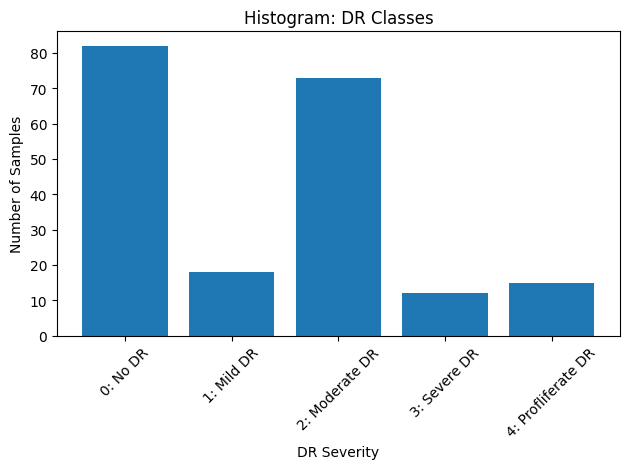

In [4]:
# YOUR CODE HERE
axis_names = labels['diagnosis'].astype('str').map({'0': '0: No DR',
                                                    '1': '1: Mild DR',
                                                    '2': '2: Moderate DR',
                                                    '3': '3: Severe DR',
                                                    '4': '4: Profliferate DR'})
axis_values = axis_names.value_counts().sort_index()

plt.bar(axis_values.index, axis_values)
plt.xticks(rotation=45)
plt.xlabel("DR Severity")
plt.ylabel("Number of Samples")
plt.title("Histogram: DR Classes")
plt.tight_layout()
plt.show()

Comment on class balance: No, the classes are not balanced. There are significantly more cases where with No DR and Moderate DR than there are for all other classes.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

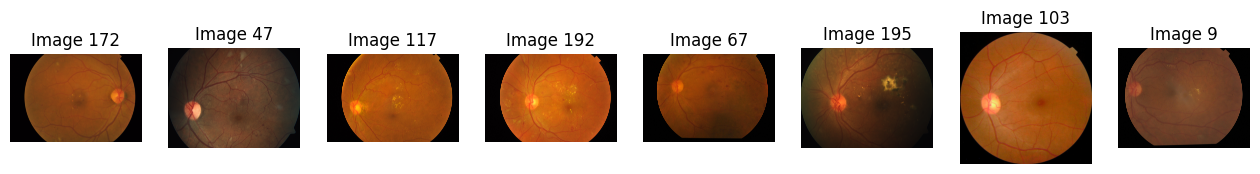

In [5]:
# FILL IN CODE HERE #
np.random.seed(0)
indices = np.random.randint(0, 200, 8)
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(2*len(indices), 2))

for ax, idx in zip(axes, indices):
    ax.imshow(images[idx])
    ax.set_title(f"Image {idx}")
    ax.axis('off')

Comment on the size, focus/orientation of the 8 images:
- Size: sizes vary slightly, but tend to be rectangular
- Focus and orientation seem to be clear and consistent across images, although some images are slighly more blurry than others

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [6]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [7]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labels based on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [8]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - normalize all pixel values by dividing by 255.0.

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [9]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    
    # create data splits (training, val, and test sets)
    # FILL IN CODE HERE #
    splits = [int(len(labels) * x) for x in np.cumsum(splits[:-1])]
    X_train, X_val, X_test = np.split(shuffled_images, splits)
    y_train, y_val, y_test = np.split(shuffled_labels, splits)
    
    # image augmentation (random flip) on training data
    X_train_augm = np.array([tf.image.flip_left_right(x).numpy() for x in X_train]) # FILL IN CODE HERE #

    # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate([X_train, X_train_augm], axis=0)# FILL IN CODE HERE #

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = np.concatenate([y_train, y_train_augm], axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    X_train = X_train / 255.
    X_val = X_val / 255.
    X_test = X_test / 255.
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

2024-03-23 15:52:34.314896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:52:34.345800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:52:34.346140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this model1l this model will serve as our baseline classifier):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets. 
11. Does the model generalize well?

In [11]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=4,
mode='max',
restore_best_weights=True)

In [12]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model1 = tf.keras.Sequential()

# add convolutional layer to model1
### YOUR CODE HERE ###
model1.add(layers.Conv2D(filters=12,
                        kernel_size=(4,4),
                        strides=(1,1),
                        padding='same',
                        data_format='channels_last',
                        activation='relu',
                        name='conv_1',
                        input_shape=(224, 224, 3)))

# add max pooling layer to model1
### YOUR CODE HERE ###
model1.add(layers.MaxPooling2D(pool_size=(2,2)))

# add dropout layer to model1
### YOUR CODE HERE ###
model1.add(layers.Dropout(0.3))

# add a flattening layer to model1
### YOUR CODE HERE ###
model1.add(layers.Flatten())

# add the classification layer to model1
### YOUR CODE HERE ###
model1.add(layers.Dense(1, activation='sigmoid', name='classification_layer'))

# build and compile model1
model1.build(input_shape=(None, 224, 224, 3))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model1 summary
### YOUR CODE HERE ###
print(model1.summary())

# train model1 on (X_train, y_train) data
### YOUR CODE HERE ###
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[early_stopping])

# evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
scores = model1.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 12)      0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 classification_layer (Dens  (None, 1)                 150529    
 e)                                                              
                                                                 
Total params: 151117 (590.30 KB)
Trainable params: 15111

None
Epoch 1/20


2024-03-23 15:52:35.494822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-23 15:52:35.604826: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-23 15:52:35.655963: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-23 15:52:35.926709: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-23 15:52:36.483802: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b5546d16610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 15:52:36.483820: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 30

6/6 [==============================] - 2s 39ms/step - loss: 716.0547 - accuracy: 0.5312 - val_loss: 33.1264 - val_accuracy: 0.5312
Epoch 2/20
6/6 [==============================] - 0s 11ms/step - loss: 7.7856 - accuracy: 0.5312 - val_loss: 0.6916 - val_accuracy: 0.5312
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 0.6934 - accuracy: 0.5312 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 4/20
6/6 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.5312 - val_loss: 0.6920 - val_accuracy: 0.5312
Epoch 5/20
6/6 [==============================] - 0s 12ms/step - loss: 0.6918 - accuracy: 0.5312 - val_loss: 0.6914 - val_accuracy: 0.5312
Epoch 5: early stopping
Accuracy: 53.12%


How many parameters does model1 have? 151,157

Comment on model1 accuracy on training vs. validation data: Training and Validation loss are virtually identical at 53.12%.

Does model1 generalize well?: Given the similarity in training versus validation accuracy, model1 appears to be generalizing very well.

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

Next, you will build a model with a more complex CNN architecture than the baseline CNN classifier above. Your tasks are as follows:

1. Implement this more complex CNN model (call this model2). Note that you are free to experiment with the number of hidden convolutional layers and hyperparameter values. The only requirement is that the minimum number of parameters be greater than 1M.
2. Explain how your implementation differs from the baseline CNN classifier.
3. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation above to the fit() method as "callbacks=[early_stopping]").
4. How many parameters does the model have?
5. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation performance relative to the baseline model.
7. Does the model generalize well?

In [13]:
### YOUR CODE HERE ###
tf.random.set_seed(1234)
np.random.seed(1234)

model2 = tf.keras.Sequential()

model2.add(layers.Conv2D(filters=32,
                        kernel_size=(4,4),
                        strides=(1,1),
                        padding='same',
                        data_format='channels_last',
                        activation='relu',
                        name='conv_1',
                        input_shape=(224, 224, 3)))

model2.add(layers.MaxPooling2D(pool_size=(2,2)))

model2.add(layers.Conv2D(filters=64,
                         kernel_size=(4,4),
                         strides=(1,1),
                         padding='same',
                         data_format='channels_last',
                         activation='relu',
                         name='conv_2'))

model2.add(layers.MaxPooling2D(pool_size=(2,2)))

model2.add(layers.Dropout(0.3))

model2.add(layers.Conv2D(filters=128,
                         kernel_size=(4,4),
                         strides=(1,1),
                         padding='same',
                         data_format='channels_last',
                         activation='relu',
                         name='conv_3'))

model2.add(layers.MaxPooling2D(pool_size=(2,2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(512, activation='relu', name='dense_layer'))

model2.add(layers.Dense(1, activation='sigmoid', name='classification_layer'))

model2.build(input_shape=(None, 224, 224, 3))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

print(model2.summary())

model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[early_stopping])

scores2 = model2.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores2[1]*100))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      1568      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      32832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 56, 56, 128)      

How many parameters does model2 have? 51,546,849

Comment on model2 performance on training vs. validation performance relative to the baseline model: There is essentially no improvement in performance. Validation accuracy remains at 53.12%.

Does model2 generalize well? Yes - validation accuracy is actually slightly higher than training accuracy.

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of model1 and model2 on unseen data. Which model performs best? Is this result expected?

1/1 [==============================] - 0s 54ms/step
Model 1 Accuracy: 37.50%


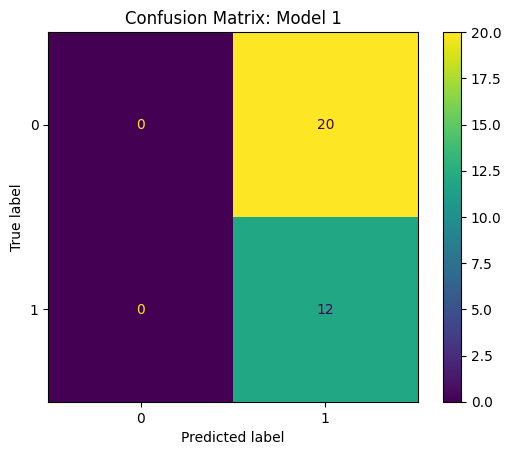

In [14]:
### YOUR CODE HERE ###
y_test_pred = model1.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model 1 Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(conf_matrix).plot(values_format='d')
plt.title("Confusion Matrix: Model 1")
plt.show()

1/1 [==============================] - 0s 51ms/step
Model 2 Accuracy: 37.50%


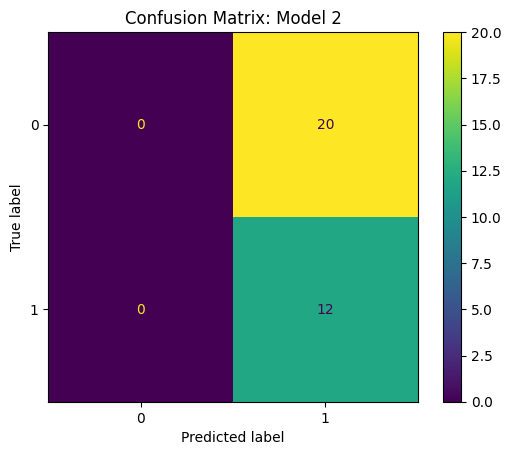

In [15]:
### YOUR CODE HERE ###
y_test_pred = model2.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model 2 Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(conf_matrix).plot(values_format='d')
plt.title("Confusion Matrix: Model 2")
plt.show()

Which model performs best? The models perform identically, both having test accuracy of 37.5%.

Is this result expected? No, this result is not expected. The second model contains more filters and densely connected layers. The second model should be able to learn more complex patterns in the image data, but isn't. This may imply that there are only more simple and somewhat unreliable patterns in the data that ultimately indicate whether or not a patient should be refered based on their imaging study.